<a href="https://colab.research.google.com/github/Zhejing-Chin/fyp/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [19]:
import tensorflow as tf

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import pickle
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as score, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121, MobileNetV2, EfficientNetB7
from tensorflow.keras.applications.densenet import preprocess_input
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Split-folders

In [ ]:
# !pip install split-folders tqdm

# Output = '/content/drive/MyDrive/FYP/extracted objects/NewData_Output'
# Input = '/content/drive/MyDrive/FYP/extracted objects/NewData/temp'

# import splitfolders
# splitfolders.ratio(Input, output=Output, seed=1337, ratio=(.8, 0.1, 0.1) )





Copying files: 0 files [00:00, ? files/s]


Copying files: 1 files [00:01,  1.61s/ files]


Copying files: 2 files [00:01,  1.21s/ files]


Copying files: 3 files [00:02,  1.07 files/s]


Copying files: 4 files [00:03,  1.21 files/s]


# Train and Validation Directory



In [ ]:
model_name = "densenet121" #"mobilenetv2" "densenet121" "efficientnetb7"
# #inter domain - GP 2
# file = "{}/Inter".format(model_name)
# train_dir = '/content/drive/MyDrive/FYP/Grocery_products/Training/Food' #train partition
# val_dir = '/content/drive/MyDrive/FYP/extracted objects/GP' #test partition

#intra domain - GP
# file = "{}/Intra".format(model_name)
# train_dir = '/content/drive/MyDrive/FYP/extracted objects/GP_Output/train' #test partition
# val_dir = '/content/drive/MyDrive/FYP/extracted objects/GP_Output/val' #test partition
# test_dir = '/content/drive/MyDrive/FYP/extracted objects/NewData'

# Real time Training Plot

In [2]:
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.acc = []
        self.f1score = []
        self.precision = []
        self.recall = []
        self.val_f1score = []
        self.val_precision = []
        self.val_recall = []
        self.logs = []
        # initialize the history dictionary
        self.H = {}
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        # loop over the logs and update the loss, accuracy, etc.
        # for the entire training process
        for (k, v) in logs.items():
          l = self.H.get(k, [])
          l.append(v)
          self.H[k] = l

        """
        Calculates and plots Precision, Recall, F1 score
        """
        # Extract from the log
        tp = logs.get('tp')
        fp = logs.get('fp')
        fn = logs.get('fn')
        val_tp = logs.get('val_tp')
        val_fp = logs.get('val_fp')
        val_fn = logs.get('val_fn')
        loss = logs.get('loss')
        acc = logs.get('accuracy')
        
        m = self.model
        preds = m.predict(train_image_gen)
        
        # Calculate
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1score = 2*(precision*recall)/(precision+recall) 

        val_precision = val_tp/(val_tp+val_fp) if (val_tp+val_fp) > 0 else 0
        val_recall = val_tp/(val_tp+val_fn) if (val_tp+val_fn) > 0 else 0
        val_f1score = 2*(val_precision*val_recall)/(val_precision+val_recall) 
        if (val_precision+val_recall) > 0 
        else 0
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.f1score.append(f1score)
        self.precision.append(precision)
        self.recall.append(recall)
        self.val_f1score.append(val_f1score)
        self.val_precision.append(val_precision)
        self.val_recall.append(val_recall)
        
        # Plots every 5th epoch
        if epoch > 2 and epoch%5==0:

            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            plt.style.use("ggplot")
            
            # plot the training loss and accuracy
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
            axes[0].plot(N, self.H["accuracy"], label="train_acc")
            axes[0].plot(N, self.H["val_accuracy"], label="val_acc")
            axes[0].set_title("Training Accuracy")
            axes[0].set_ylabel('Accuracy')
            axes[0].set_xlabel('Epoch #')
            axes[0].set_ylim(0,1)
            axes[0].legend(['train', 'val'], loc='upper left')

            axes[1].plot(N, self.H["loss"], label="train_loss")
            axes[1].plot(N, self.H["val_loss"], label="val_loss")
            axes[1].set_title("Training Loss") #len(self.H["loss"])
            axes[1].set_xlabel("Epoch #")
            axes[1].set_ylabel("Loss")
            axes[1].legend(['train', 'val'], loc='upper left')

            fig.suptitle("At Epoch No. {}".format(epoch))

            plt.tight_layout()
            plt.savefig(timestamp+'/model_loss_acc{}.png'.format(str(fold_var)), bbox_inches='tight')
   
            fig, ax = plt.subplots(1,3, figsize=(12,4))
            ax = ax.ravel()
            ax[0].plot(N, self.precision, label = "train_Precision", c='red')
            ax[0].plot(N, self.val_precision, label = "val_Precision", c='blue')

            ax[1].plot(N, self.recall, label = "train_Recall", c='red')
            ax[1].plot(N, self.val_recall, label = "Val_Recall", c='blue')

            ax[2].plot(N, self.f1score, label = "train_F1 score", c='red')
            ax[2].plot(N, self.val_f1score, label = "Val_F1 score", c='blue')

            ax[0].set_title("Precision at Epoch No. {}".format(epoch))
            ax[1].set_title("Recall at Epoch No. {}".format(epoch))
            ax[2].set_title("F1-score at Epoch No. {}".format(epoch))
            ax[0].set_xlabel("Epoch #")
            ax[1].set_xlabel("Epoch #")
            ax[2].set_xlabel("Epoch #")
            ax[0].set_ylabel("Precision")
            ax[1].set_ylabel("Recall")
            ax[2].set_ylabel("F1 score")
            ax[0].set_ylim(0,1)
            ax[1].set_ylim(0,1)
            ax[2].set_ylim(0,1)
            ax[0].legend(['train', 'val'], loc='upper left')
            ax[1].legend(['train', 'val'], loc='upper left')
            ax[2].legend(['train', 'val'], loc='upper left')
            
            plt.savefig(timestamp+'/model_cm{}.png'.format(str(fold_var)), bbox_inches='tight')
			      # plt.close()
            plt.show();

## Check Image

In [3]:
# ## check image file 
# import glob
# from PIL import Image
# import os

# for i in os.listdir(train_dir):
#   if i == 'Cheese':
#     for filename in glob.glob(train_dir + '/' + i + '/*.jpg'): #assuming gif
#         print(filename)
#         im = Image.open(filename)
#         display(im)
#         # break
# print(os.listdir(train_dir))



# Create folder with [model] [augmentation] timestamp

In [ ]:
#  create folder with timestamp for model checkpoint
import errno
from datetime import datetime
import pytz

def foldercreation(folder, previous="", ct=False, simple=True, augmented=False):
    d_a = "No Aug"
    m = "Complex"
    if ct:
      mydir = os.path.join(
          folder, 
          "[{}] ".format(previous)+datetime.now(pytz.timezone('Asia/Kuala_Lumpur')).strftime('%Y-%m-%d_%H-%M-%S'))
    else:
      if augmented:
        d_a = "Aug"
      if simple:
        m = "Simple"
      mydir = os.path.join(
          folder, 
          "[{}] [{}] ".format(m, d_a)+datetime.now(pytz.timezone('Asia/Kuala_Lumpur')).strftime('%Y-%m-%d_%H-%M-%S'))
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise  # This was not a "directory exist" error..
            
    return mydir


# OPTION 1: CREATE NEW MODEL

## Image Data Generator

In [ ]:
batch_size = 32

augmented = True

# train_val_image_gen = ImageDataGenerator(
#     rotation_range = 90, 
#     horizontal_flip = True,
#     vertical_flip = True,
#     brightness_range = [0.5,1.5],
#     shear_range	= 0.2,
#     zoom_range = 0.2,
#     preprocessing_function = preprocess_input
# )

img_width, img_height = 224, 224

test_image_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

# train_image_gen = train_val_image_gen.flow_from_directory(batch_size = batch_size,
#                                                           directory = train_dir,
#                                                           shuffle = True,
#                                                           target_size = (img_width, img_height),
#                                                           class_mode = 'categorical')


# val_image_gen = train_val_image_gen.flow_from_directory(batch_size = batch_size,
#                                                           directory = val_dir,
#                                                           shuffle = True,
#                                                           target_size = (img_width, img_height),
                                                          # class_mode = 'categorical')

test_image_gen = test_image_gen.flow_from_directory(batch_size = batch_size,
                                                          directory = test_dir,
                                                          shuffle = False,
                                                          target_size = (img_width, img_height),
                                                          class_mode = 'categorical')
# num_of_categories = len(train_image_gen.class_indices)

Found 5370 images belonging to 27 classes.


In [19]:
# OPTION 1: Create new model + Perform transfer learning 
img_width, img_height = 224, 224

def create_new_model():
  # base_model = DenseNet121(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3)) 
  # base_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))
  base_model = EfficientNetB7(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))

  base_model.trainable = False

  model = keras.Sequential([
      base_model,
      GlobalAveragePooling2D(input_shape=(7, 7, 1024)),
      BatchNormalization(),
      Dropout(0.5),
      Dense(1024,activation='relu'),
      Dense(512,activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(27, activation='softmax')
  ])
  return model

simple = False
metrics = [
      'accuracy',
      tf.keras.metrics.TruePositives(name="tp"),
      tf.keras.metrics.TrueNegatives(name="tn"),
      tf.keras.metrics.FalseNegatives(name="fn"),
      tf.keras.metrics.FalsePositives(name="fp"),
  ]

model = create_new_model()
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = metrics)
model.summary()

258080768/258076736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2560)              10240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2622464   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_____________________________________________________

## Transfer Learning

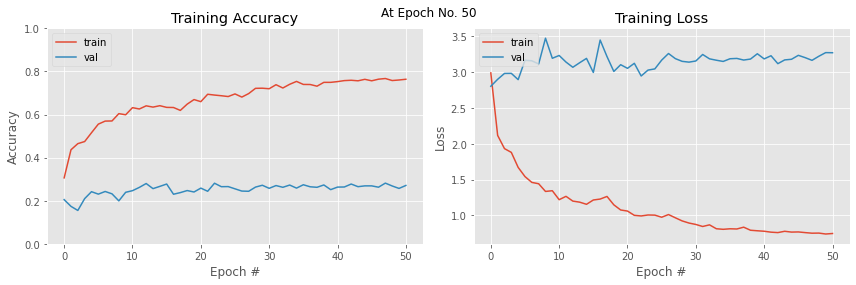

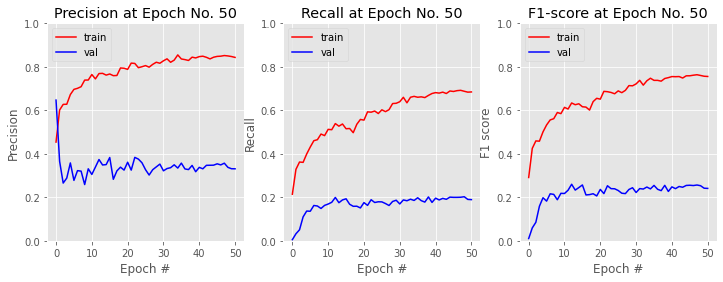

In [ ]:
import pickle

#GP 2 -- GP Train + Test paritions
#GP -- GP Test partition
timestamp = foldercreation('/content/drive/My Drive/FYP/checkpoints/{}'.format(file), simple=False, augmented=True)
SAVE_PERIOD = 10
steps_per_epoch = train_image_gen.samples // train_batch_size
print("Snapshot: ", timestamp)

#callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=50)
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
plot_metrics = TrainingPlot()
checkpoint = ModelCheckpoint(
    filepath = timestamp+'/model_weights_{epoch}.h5', 
    monitor = 'val_loss',
    save_weights_only = False,
    save_best_only = False,
    verbose = 1,
    save_freq = int(SAVE_PERIOD * steps_per_epoch)) #'epoch') #

with tf.device('/device:GPU:0'):
  model_history = model.fit(
                train_image_gen,
                steps_per_epoch = train_image_gen.samples // train_batch_size,
                epochs = 500,
                verbose = 1,
                callbacks = [es, anne, checkpoint, plot_metrics],
                validation_data = val_image_gen,
                validation_steps = val_image_gen.samples // val_batch_size
                )
with open(timestamp + '/TrainHistoryDict', 'wb') as file_pi:
  pickle.dump(model_history.history, file_pi)

## Fine-tuning 
unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

In [ ]:
base_model.trainable = True
model.compile(optimizer = keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = metrics)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [ ]:
print(timestamp)

/content/drive/My Drive/FYP/checkpoints/mobilenetv2/Inter/[Complex] [Aug] 2021-01-31_16-36-55


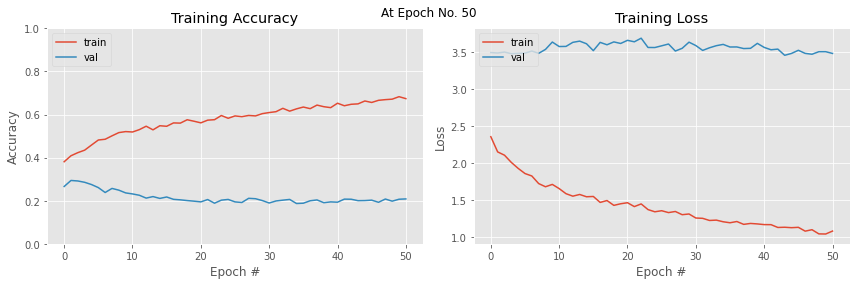

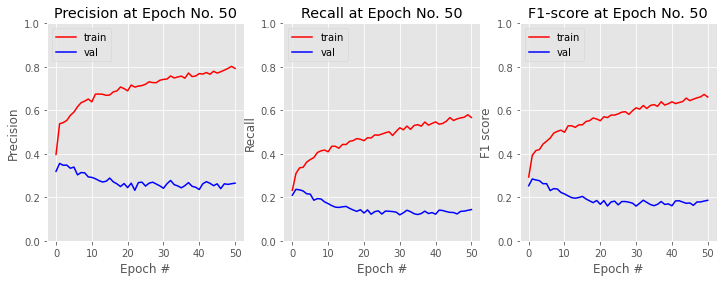

In [ ]:

# timestamp = foldercreation('/content/drive/My Drive/FYP/checkpoints/{}'.format(model_name), previous=timestamp.split('/')[-1], finetune=True)
timestamp = timestamp+'/fine-tune' #previous section dir
# timestamp = '/content/drive/My Drive/FYP/checkpoints/mobilenetv2/Intra/[Complex] [Aug] 2021-01-24_22-15-46/fine-tune'
SAVE_PERIOD = 10
steps_per_epoch = train_image_gen.samples // train_batch_size
print(timestamp)

#callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=50)
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
plot_metrics = TrainingPlot()
checkpoint = ModelCheckpoint(
    filepath = timestamp+'/model_weights_{epoch}.h5', 
    monitor = 'val_loss',
    save_weights_only = False,
    save_best_only = False,
    verbose = 1,
    save_freq = int(SAVE_PERIOD * steps_per_epoch)) #'epoch') #

with tf.device('/device:GPU:0'):
  model_history = model.fit(
                train_image_gen,
                steps_per_epoch = train_image_gen.samples // train_batch_size,
                epochs = 500,
                verbose = 1,
                callbacks = [es, anne, checkpoint, plot_metrics],
                validation_data = val_image_gen,
                validation_steps = val_image_gen.samples // val_batch_size
                )
with open(timestamp + '/TrainHistoryDict', 'wb') as file_pi:
  pickle.dump(model_history.history, file_pi)

In [ ]:
print(timestamp)


/content/drive/My Drive/FYP/checkpoints/densenet121/fine-tune/[[Complex] [Aug] 2021-01-10_20-37-21] 2021-01-24_15-48-05


# OPTION 2: DOWNLOAD PRETRAINED MODEL

In [20]:
#### OPTION 2: DOWNLOAD PRETRAINED MODEL FROM GOOGLE DRIVE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####

import glob

# latest_model = "/content/drive/My Drive/FYP/checkpoints/densenet121/Intra/[Complex] [Aug] 2021-01-24_14-45-43/model_weights_50.h5"
# latest_model = "/content/drive/My Drive/FYP/checkpoints/mobilenetv2/Intra/[Complex] [Aug] 2021-01-24_22-15-46/model_weights_50.h5"
# latest_model =  '/content/drive/My Drive/FYP/checkpoints/efficientnetb7/Intra/[Complex] [Aug] 2021-01-25_19-53-04/model_weights_50.h5'

# latest_model =  '/content/drive/My Drive/FYP/checkpoints/efficientnetb7/ContinueTraining/[[Complex] [Aug] 2021-01-25_19-53-04] 2021-01-29_16-37-46/model_weights_50.h5'
latest_model =  '/content/drive/My Drive/FYP/checkpoints/densenet121/ContinueTraining/[[Complex] [Aug] 2021-01-24_14-45-43] 2021-01-24_16-56-18/model_weights_50.h5'
# latest_model =  '/content/drive/My Drive/FYP/checkpoints/mobilenetv2/ContinueTraining/[[Complex] [Aug] 2021-01-24_22-15-46] 2021-01-25_17-21-42/model_weights_50.h5'

print(latest_model)
print(latest_model.split('/')[-2])


/content/drive/My Drive/FYP/checkpoints/densenet121/ContinueTraining/[[Complex] [Aug] 2021-01-24_14-45-43] 2021-01-24_16-56-18/model_weights_50.h5
[[Complex] [Aug] 2021-01-24_14-45-43] 2021-01-24_16-56-18


In [21]:
model = tf.keras.models.load_model(latest_model, compile=True)
# for layer in model.layers[:-8]:
#     layer.trainable=False

# model.summary()

In [32]:
model_name = latest_model.split('/')[6]
model_name

'densenet121'

## Image Data Generator

In [5]:
train_dir = '/content/drive/MyDrive/FYP/extracted objects/NewData_Output/train'
val_dir =  '/content/drive/MyDrive/FYP/extracted objects/NewData_Output/val'
test_dir =  '/content/drive/MyDrive/FYP/extracted objects/NewData_Output/test'

train_val_image_gen = ImageDataGenerator(
    rotation_range = 90, 
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.5,1.5],
    shear_range	= 0.2,
    zoom_range = 0.2,
    preprocessing_function = preprocess_input
)
augmented = True

train_batch_size = 32
val_batch_size = 32
test_batch_size = 32
img_width, img_height = 224, 224

test_image_gen = ImageDataGenerator(preprocessing_function = preprocess_input)


train_image_gen = train_val_image_gen.flow_from_directory(batch_size = train_batch_size,
                                                          directory = train_dir,
                                                          shuffle = True,
                                                          target_size = (img_width, img_height),
                                                          class_mode = 'categorical')


val_image_gen = train_val_image_gen.flow_from_directory(batch_size = val_batch_size,
                                                          directory = val_dir,
                                                          shuffle = True,
                                                          target_size = (img_width, img_height),
                                                          class_mode = 'categorical')

test_image_gen = test_image_gen.flow_from_directory(batch_size = test_batch_size,
                                                          directory = test_dir,
                                                          shuffle = False,
                                                          target_size = (img_width, img_height),
                                                          class_mode = 'categorical')
num_of_categories = len(train_image_gen.class_indices)

Found 4284 images belonging to 27 classes.
Found 526 images belonging to 27 classes.
Found 560 images belonging to 27 classes.


## KFold cross validation

In [33]:
# StratifiedKFold
path = '/content/drive/MyDrive/FYP/extracted objects/'
train_data = pd.read_csv(path + 'cs.csv')
Y = train_data[['label']]
X = train_data[['file_path']]
                         
skf = StratifiedKFold(n_splits = 4, random_state = 1, shuffle = True) 

idg = ImageDataGenerator(
    rotation_range = 90, 
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.5,1.5],
    shear_range	= 0.2,
    zoom_range = 0.2,
    preprocessing_function = preprocess_input
)

file = "{}/Kfold".format(model_name)


In [34]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [35]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
ALL_MSE = []

batch_size = 32
image_dir = '/content/drive/MyDrive/FYP/extracted objects/NewData'
SAVE_PERIOD = 10
timestamp = '/content/drive/My Drive/FYP/checkpoints/{}/[Complex] [Aug] 2021-02-06_14-22-18'.format(file)
# timestamp = foldercreation('/content/drive/My Drive/FYP/checkpoints/{}'.format(file), simple=False, augmented=True)
fold_var = 1

es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=50)
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
# plot_metrics = TrainingPlot()
img_width, img_height = 224, 224

for train_index, val_index in skf.split(X,Y):
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  train_image_gen = idg.flow_from_dataframe(training_data, directory = image_dir,
                    x_col = "file_path", y_col = "label", target_size = (img_width, img_height),
                    class_mode = "categorical", shuffle = True, batch_size=batch_size)
  val_image_gen  = idg.flow_from_dataframe(validation_data, directory = image_dir,
              x_col = "file_path", y_col = "label", target_size = (img_width, img_height),
              class_mode = "categorical", shuffle = True, batch_size=batch_size)
  # break

  # LOAD INTRA-DOMAIN CLASSIFIER
  model_k = tf.keras.models.load_model(latest_model, compile=True)
  
  # CREATE CALLBACKS
  # checkpoint = tf.keras.callbacks.ModelCheckpoint(timestamp+'/'+get_model_name(fold_var), 
  #             monitor='val_accuracy', verbose=1, 
  #             save_best_only=True, mode='max')
  # This saves the best model

  # FIT THE MODEL
  # with tf.device('/device:GPU:0'):
  #   model_history = model_k.fit(
  #                 train_image_gen,
  #                 steps_per_epoch = train_image_gen.samples // batch_size,
  #                 epochs = 500,
  #                 verbose = 1,
  #                 callbacks = [es, anne, checkpoint, plot_metrics],
  #                 validation_data = val_image_gen,
  #                 validation_steps = val_image_gen.samples // batch_size
  #                 )
  # with open(timestamp + '/TrainHistoryDict{}.pkl'.format(str(fold_var)), 'wb') as file_pi:
  #   pickle.dump(model_history.history, file_pi)

  # LOAD BEST MODEL to evaluate the performance of the model
  ground_truth = val_image_gen.classes

  model_k.load_weights(timestamp+"/model_"+str(fold_var)+".h5")

  # results = model_k.evaluate(val_image_gen)
  # results = dict(zip(model_k.metrics_names,results))

  ypred = model.predict(val_image_gen, verbose=1) #probability
  predictions = np.argmax(ypred,axis=1)

  MSE = mean_squared_error(ground_truth, predictions)

  ALL_MSE.append(MSE)

  # VALIDATION_ACCURACY.append(results['accuracy'])
  # VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1
	

Found 4027 validated image filenames belonging to 27 classes.
Found 1343 validated image filenames belonging to 27 classes.
42/42 [==============================] - 455s 11s/step
Found 4027 validated image filenames belonging to 27 classes.
Found 1343 validated image filenames belonging to 27 classes.
42/42 [==============================] - 444s 11s/step
Found 4028 validated image filenames belonging to 27 classes.
Found 1342 validated image filenames belonging to 27 classes.
42/42 [==============================] - 441s 11s/step
Found 4028 validated image filenames belonging to 27 classes.
Found 1342 validated image filenames belonging to 27 classes.
42/42 [==============================] - 442s 11s/step


In [17]:
print("Average accuracy: ", sum(VALIDATION_ACCURACY) / len(VALIDATION_ACCURACY))

print(VALIDATION_ACCURACY)

print("\nAverage loss: ", sum(VALIDATION_LOSS) / len(VALIDATION_LOSS))

print(VALIDATION_LOSS)

Average accuracy:  0.9001864790916443
[0.8965003490447998, 0.9024571776390076, 0.9038748145103455, 0.8979135751724243]

Average loss:  0.3505985736846924
[0.3573363423347473, 0.35034093260765076, 0.31673604249954224, 0.3779809772968292]


In [42]:
ALL_MSE = [126.43410275502606, 125.36783320923305, 125.58569299552906, 124.69970193740686]

RMSE = []
for i in ALL_MSE:
  RMSE.append(math.sqrt(i))


print("Average Root Mean Square Error: ", sum(RMSE) / len(RMSE))

print(ALL_MSE)


Average Root Mean Square Error:  11.203618537729703
[126.43410275502606, 125.36783320923305, 125.58569299552906, 124.69970193740686]


## Continue Training


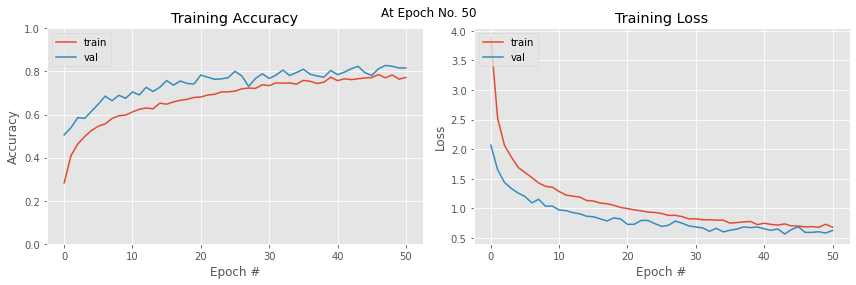

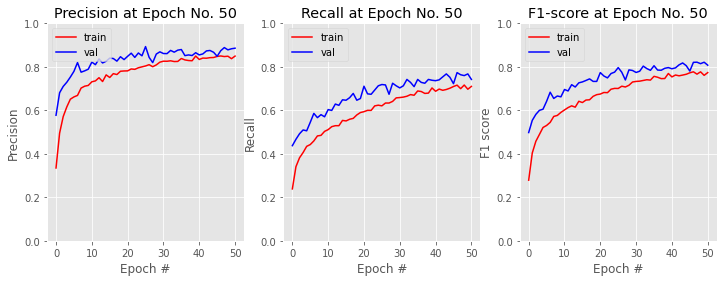

In [ ]:
import pickle
file = "{}/ContinueTraining".format(model_name)

#GP 2 -- GP Train + Test paritions
#GP -- GP Test partition
timestamp = foldercreation('/content/drive/My Drive/FYP/checkpoints/{}'.format(file), latest_model.split('/')[-2], True)
SAVE_PERIOD = 10
steps_per_epoch = train_image_gen.samples // train_batch_size
print(timestamp)

#callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=50)
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
plot_metrics = TrainingPlot()
checkpoint = ModelCheckpoint(
    filepath = timestamp+'/model_weights_{epoch}.h5', 
    monitor = 'val_loss',
    save_weights_only = False,
    save_best_only = False,
    verbose = 1,
    save_freq = int(SAVE_PERIOD * steps_per_epoch)) #'epoch') #

with tf.device('/device:GPU:0'):
  model_history = model.fit(
                train_image_gen,
                steps_per_epoch = train_image_gen.samples // train_batch_size,
                epochs = 500,
                verbose = 1,
                callbacks = [es, anne, checkpoint, plot_metrics],
                validation_data = val_image_gen,
                validation_steps = val_image_gen.samples // val_batch_size
                )
with open(timestamp + '/TrainHistoryDict', 'wb') as file_pi:
  pickle.dump(model_history.history, file_pi)

# Evaluation

## Image preprocessing for test set

In [26]:
# all will be under 
path = '/content/drive/MyDrive/FYP/detection_results_filtered_iou/'
# test_dir = 'res_tesco2_0.5_2021-02-22 15:23:08.294966'
test_dir = 'res_tesco_0.5_2021-02-03 03:25:04.625617'

test_batch_size = 32
img_width, img_height = 224, 224

test_image_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_image_gen = test_image_gen.flow_from_directory(batch_size = test_batch_size,
                                                          directory = path + test_dir,
                                                          shuffle = False,
                                                          target_size = (img_width, img_height),
                                                          class_mode = 'categorical')
num_of_categories = len(test_image_gen.class_indices)

Found 1691 images belonging to 27 classes.


## Predict

In [27]:
ypred = model.predict(test_image_gen, verbose=1) #probability
scores = model.evaluate(test_image_gen, verbose=1)
print('\nAccuracy on testing data: {:.2f}% \nError on testing data: {:.2f}%'.format(scores[1], 1 - scores[1]))   

# Get the predictions labels
predictions = np.argmax(ypred,axis=1)

# Get the filenames from the generator
fnames = test_image_gen.filenames

# Get the ground truth from generator
ground_truth = test_image_gen.classes

# Get the label to class mapping from the generator
label2index = test_image_gen.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

nVal = test_image_gen.samples

# Show the errors
errors = np.where(predictions != ground_truth)[0]
accurates = np.where(predictions == ground_truth)[0]

print("No of errors = {}/{}".format(len(errors),nVal))
print("No of accurates = {}/{}".format(len(accurates), nVal))


53/53 [==============================] - 6s 112ms/step - loss: 3.1385 - accuracy: 0.3406 - tp: 500.0000 - tn: 43236.0000 - fn: 1191.0000 - fp: 730.0000

Accuracy on testing data: 0.34% 
Error on testing data: 0.66%
No of errors = 1115/1691
No of accurates = 576/1691


In [28]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(ground_truth, predictions)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

8.766300184440057


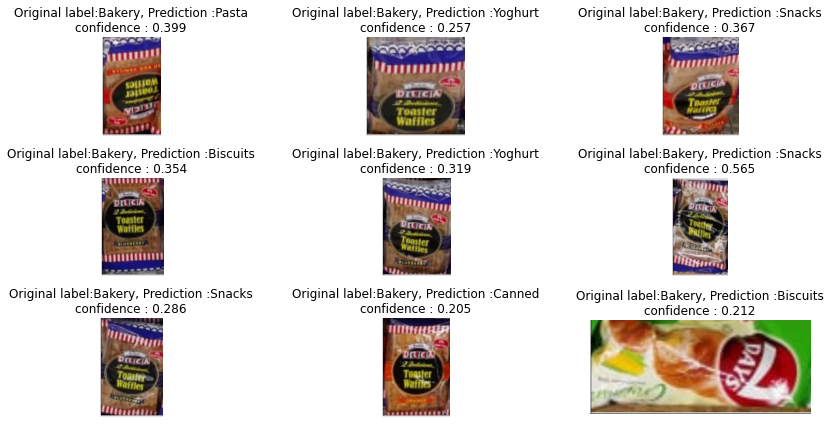

In [9]:
# Find the images that were predicted wrongly and who the images along with the predicted class
fig=plt.figure(figsize=(12, 6))

for i in range(0, 9):
    pred_class = np.argmax(ypred[errors[i]])
    pred_label = idx2label[pred_class]
    
    title =  'Original label:{}, Prediction :{}\nconfidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        ypred[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(path+test_dir,fnames[errors[i]]))
    # plt.axis('off')
    subplot = 331 + i
    ax = plt.subplot(subplot)
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(original)

plt.tight_layout()
# plt.show()

In [8]:
timestamp = path + 'result_mobilenet'

In [13]:
# ['Bakery', 'Biscuits', 'Bonbons', 'Canned', 'Cereals', 'Chips', 'Choco', 'Chocolate', 'Coffee', 'Creme', 'DriedFruitsAndNuts', 'IceTea', 'Juices', 'Milk', 'Oil-Vinegar', 'Pasta', 'Rice', 'Sauces', 'Snacks', 'SoftDrinks', 'Soups', 'Spices', 'Spreads', 'Tea', 'Water', 'Yoghurt']

label = test_image_gen.class_indices
label = list(label.keys())

# precision, recall, fscore, support
Ypred = np.argmax(ypred, axis=1)
Ytrue = test_image_gen.classes

precision, recall, fscore, support = score(Ytrue, Ypred, average=None)

avg = score(Ytrue, Ypred, average="weighted")[:-1]
metrics = {'Label': label, 'Precision': precision, 'Recall': recall,
           'F1-Score': fscore, 'Support': support}

df = pd.DataFrame(metrics, columns = metrics.keys())
support = df["Support"]
total = support.sum() 
avg = ("Avg/total",) + avg + (total,)

df2 = pd.DataFrame([avg], columns = metrics.keys())
df = df.append(df2, ignore_index=True)
df.to_csv(timestamp + '/finetune_metrics.csv', index=False, header=True)
df

,Label,Precision,Recall,F1-Score,Support
0,Bakery,0.322581,0.208333,0.253165,48
1,Biscuits,0.132075,0.466667,0.205882,15
2,Bonbons,0.000000,0.000000,0.000000,11
3,Canned,0.148936,0.538462,0.233333,39
4,Cereals,0.142857,1.000000,0.250000,2
5,Cheese,0.000000,0.000000,0.000000,39
6,Chips,0.163743,0.666667,0.262911,42
7,Choco,0.666667,0.833333,0.740741,12
8,Chocolate,0.000000,0.000000,0.000000,22
9,Coffee,0.571429,0.195122,0.290909,41


Normalized confusion matrix


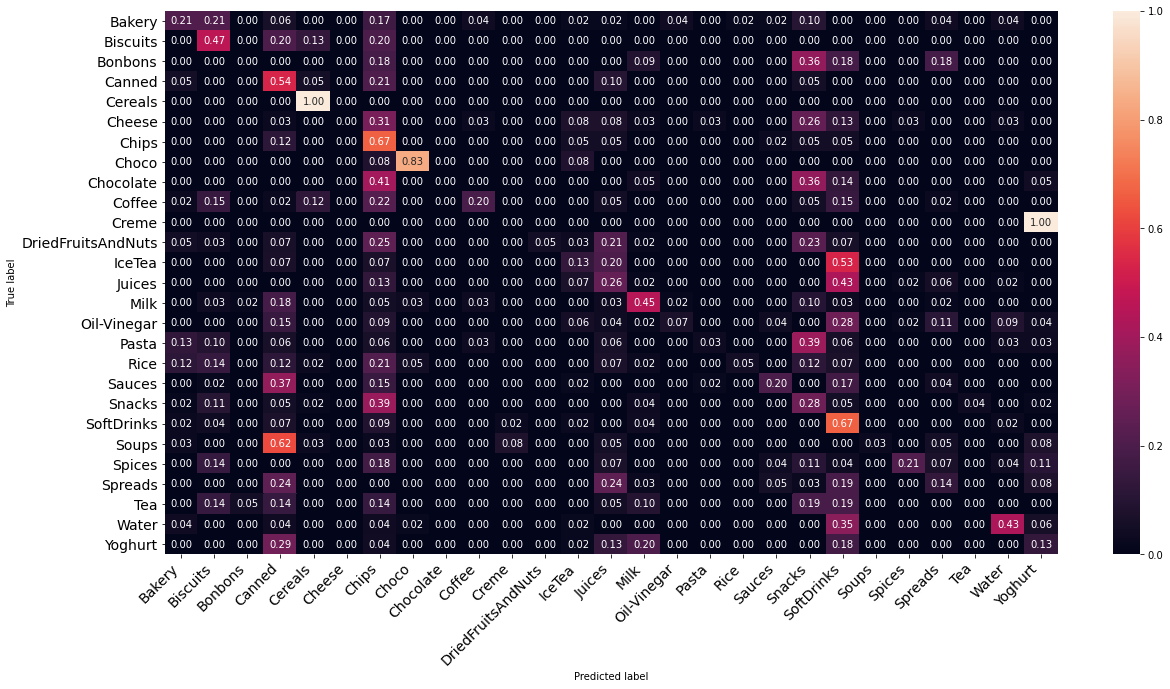

In [14]:
# Plot CM
# label = train_image_gen.class_indices
label = test_image_gen.class_indices

label = list(label.keys())

def print_confusion_matrix(confusion_matrix, class_names, normalize = True, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fmt = '.2f' if normalize else 'd'
    figsize = (20, 10) if normalize else (10, 7)

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, vmin=0, vmax=1)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(timestamp +'/finetune_confusion_metrics.png', bbox_inches='tight')

Ypred = np.argmax(ypred, axis=1)
Ytrue = test_image_gen.classes

#need to normalize .. use seaborn (100%)
cm = confusion_matrix(Ytrue, Ypred)
print_confusion_matrix(cm, label)
